# TFSa17 ML: Deep Learning & CNN 

In [10]:
import keras

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16539635663626995974
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 16733805800480116739
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]


Задача этой домашки – понять, как работать с keras и вообще с нейронками.

Самая сложная часть этого задания в том, чтобы развернуть все окружение. Вам потребуется видеокарта nvidia с по крайней мере 2Гб памяти. Мануал по облакам выложу отдельно.

В качестве фреймворка нейронок будем использовать keras. Keras – это высокоуровневая надстройка над tensorflow. Документация и мануалы живут здесь: https://keras.io/

Дедлайн 31 октября в 8:00. К этому моменту нужно получить какие-то результаты на kaggle и прислать тетрадки с решениями в anytask

## Задача 1

Посчитайте, сколько параметров (весов) в этом слое:

In [ ]:
input_x = keras.layers.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=True)(input_x)
# (5 * 5 + 1) * 3 = 228

А сколько в этой модели?

In [ ]:
input_x = keras.layers.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1))(input_x)
x = keras.layers.Flatten()(x)
output_x = keras.layers.Dense(10)(x)

model = keras.models.Model(inputs=input_x, outputs=output_x)

Можно просто вызвать `model.summary()`, чтобы посмотреть правильный ответ. Мне же нужно от вас развернутое объяснение, почему ответ именно такой



In [ ]:
model.summary()

# Задача 2

Предлагаю порешать вот это соревнование: https://www.kaggle.com/c/dog-breed-identification.
Будем определять породу собак по фото.

От вас требуется получить более-менее достойное качество, например находиться в первой половине лидерборда. Пожалуйста, в названии команды указывайте <span style='color: red'>(TFS)</span> (это вот тут https://www.kaggle.com/c/dog-breed-identification/team). У вас должен быть ноутбук, где будет:
* решение, сделанное руками
* решение, где вы дообучаете предобученную на imagenet модель (https://keras.io/applications/)

Не важно, какое решение из двух лучше, главное -- это лидерборд и наличие двух моделей в ноутбуке

Ниже приведу пример базового решения для MNIST (нет, MNIST зарешивать не будем):

### Using pretrained model VGG19

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
df_train = pd.read_csv('labels.csv')
df_test = pd.read_csv('sample_submission.csv')

In [ ]:
df_train.head(10)

In [ ]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [ ]:
one_hot_labels = np.asarray(one_hot)

In [ ]:
im_size = 224

In [ ]:
x_train = []
y_train = []
x_test = []

In [ ]:
i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread('train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

In [ ]:
for f in tqdm(df_test['id'].values):
    img = cv2.imread('test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

In [ ]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

In [ ]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

In [ ]:
num_class = y_train_raw.shape[1]

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=56)

In [ ]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1, batch_size=32)

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1, batch_size=128)

In [ ]:
preds = model.predict(x_test, verbose=1)

In [ ]:
sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

In [ ]:
sub.to_csv("vgg19_90size.csv", index=False)

### VGG16 + Xception + Inception

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression

In [ ]:
labels = pd.read_csv('labels.csv')

In [ ]:
INPUT_SIZE = 224
POOLING = 'avg'
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(X_valid, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

In [ ]:
train_vgg_bf.shape

#### LogReg on VGG bottleneck features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [ ]:
NUM_CLASSES = 120
SEED = 50
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (Y_train * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [ ]:
print('Validation VGG LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((Y_valid * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

#### Extract Xception bottleneck features

In [ ]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(X_valid, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

In [ ]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)

In [ ]:
test_x_bf.shape

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (Y_train * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((Y_valid * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

#### Extract Inception bottleneck features

In [ ]:
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(X_train, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(X_valid, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

In [ ]:
test_i_bf = inception_bottleneck.predict(x_test, batch_size=32, verbose=1)

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (Y_train * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [ ]:
print('Validation Inception LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((Y_valid * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

#### LogReg on all bottleneck features

In [ ]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (Y_train * range(NUM_CLASSES)).sum(axis=1))
train_probs = logreg.predict_proba(X)
train_preds = logreg.predict_proba(X)
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Train Xception + Inception LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Train Xception + Inception LogLoss {}'.format(log_loss(Y_valid, valid_probs)))

print('Validation Xception + Inception LogLoss {}'.format(log_loss(Y_valid, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((Y_valid * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

In [ ]:
SEED = 50
T = np.hstack([test_x_bf, test_i_bf])
preds = logreg.predict_proba(T)

In [ ]:
sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

In [ ]:
sub.to_csv("xception_inception.csv", index=False)

#### Use Xception and Inception features in NN

In [17]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
import pandas as pd

In [4]:
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [12]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:31<00:00, 325.75it/s]


In [18]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [19]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

10222/10222 [==============================] - 216s   


In [24]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=256, epochs=20, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/20
9199/9199 [==============================] - 0s - loss: 2.4388 - acc: 0.5052 - val_loss: 0.8964 - val_acc: 0.8113
Epoch 2/20
9199/9199 [==============================] - 0s - loss: 0.6985 - acc: 0.8204 - val_loss: 0.5990 - val_acc: 0.8358
Epoch 3/20
9199/9199 [==============================] - 0s - loss: 0.5145 - acc: 0.8575 - val_loss: 0.5266 - val_acc: 0.8446
Epoch 4/20
9199/9199 [==============================] - 0s - loss: 0.4267 - acc: 0.8824 - val_loss: 0.4989 - val_acc: 0.8534
Epoch 5/20
9199/9199 [==============================] - 0s - loss: 0.3728 - acc: 0.8981 - val_loss: 0.4752 - val_acc: 0.8524
Epoch 6/20
9199/9199 [==============================] - 0s - loss: 0.3233 - acc: 0.9086 - val_loss: 0.4595 - val_acc: 0.8524
Epoch 7/20
9199/9199 [==============================] - 0s - loss: 0.2872 - acc: 0.9209 - val_loss: 0.4505 - val_acc: 0.8553
Epoch 8/20
9199/9199 [==============================] - 0s - loss: 0.2582 - a

In [13]:
from keras.preprocessing.image import ImageDataGenerator # data augmentation

#### Визуализация

Text(0.5,0,'epoch')

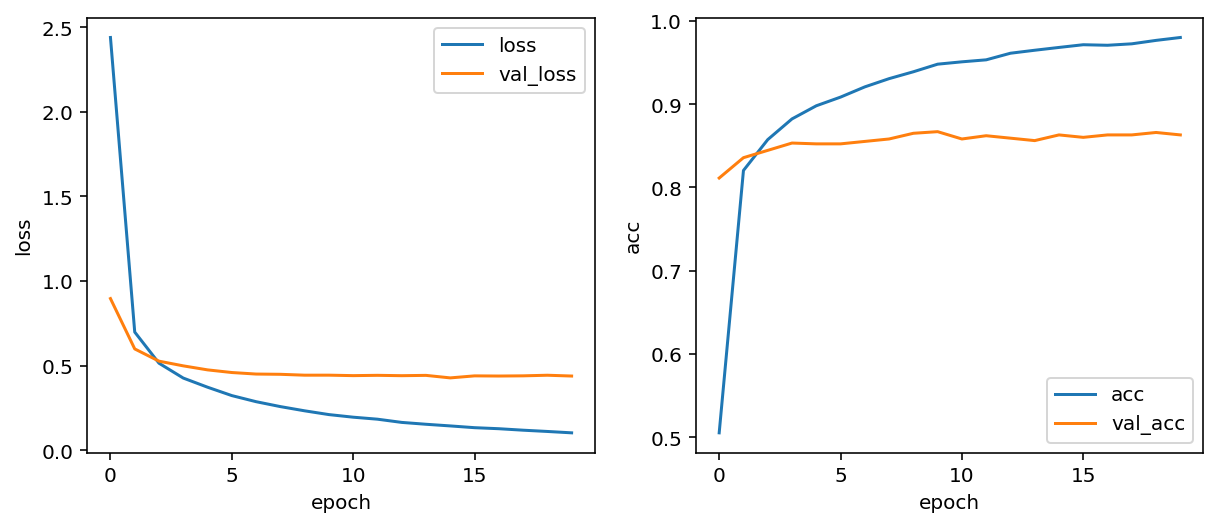

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

In [26]:
df2 = pd.read_csv('sample_submission.csv')

In [27]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('test/%s.jpg' % df2['id'][i]), (width, width))

100%|██████████| 10357/10357 [00:26<00:00, 386.89it/s]


In [28]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

10357/10357 [==============================] - 219s   


In [29]:
y_pred = model.predict(features_test, batch_size=128)

In [30]:
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]

In [31]:
df2.to_csv('preds_xcep_incep_nn.csv', index=None)

### Custom CNN

In [ ]:
import matplotlib.pyplot as plt # for seeing the images
%matplotlib inline
import cv2 # for image processing
import glob # for file handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output # to get the files in currect folder
from keras.utils import to_categorical # to convert to one-hot encodings
import tqdm # progress bar
from collections import Counter # for getting breed data

# Importing ML Dependencies
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

####  Custom CNN 1

In [ ]:
NUM_CLASSES = 120
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (2,2), padding = 'same',
                 activation = 'relu', input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))

print(model.summary())

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid), verbose=1, batch_size=128)

In [ ]:
predicted = model.predict_proba(total_images_test, batch_size=64)

In [ ]:
predicted_df = pd.DataFrame(predicted, columns=['id'].append(test_submission.columns), index=test_image_names)
predicted_df.head()

In [ ]:
predicted_df.describe()

In [ ]:
predicted_df.to_csv('custom1.csv',sep=',')

## MNIST

Вот пример базового варианта сетки, которая будет классифицировать MNIST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
# скачиваем данные
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape) # размер train датасета -- 60к черно-белых картинок размером 28x28
plt.imshow(x_train[0], cmap='gray') # посмотрим на одну из картинок

In [ ]:
batch_size = 128 # это количество картинок, по которым происходит один проход по нейронке, а потом -- один шаг в сторону антиградиента 
num_classes = 10 # количество классов == количество цифр
epochs = 12 # эпоха -- это один обход всего датасета. здесь для обучения мы прогоняем всю выборку 12 раз 
img_rows, img_cols = 28, 28 # размер картинок

In [ ]:
p = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
p.shape

In [ ]:
p[0].shape

In [ ]:
# есть два подхода к порядку размерностей тензора:
# как у theano (channels_first): [objects, channels, rows, cols]
# как у tensorflow (channels_last): [objects, rows, cols, channels]
# этот порядок задается в keras.json (https://keras.io/backend/#kerasjson-details)
# по дефолту все стоит для tensorflow и скорее всего ничего менять не надо

# в датасете MNIST размерность 3 (objects, rows, cols), так как у черно-белых картинок один канал.
# Нужно привести матрицы к виду [objects, rows, cols, channels]
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# картинки обычно 24битные, по 8 бит на канал, то есть для каждого канала цвет имеет интенсивность от 0 до 255.
# приведем интенсивности пикселей в [0, 1]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# мы хотим получить на выходе нейронки, к какому из 10 классов относится текущая картинка.
# Нейроны без нелинейности выдают непрерывные значения. Можно было бы, например, сделать на выход один нейрон 
# и пытаться оптимизировать его через MSE. Например, если на каритнке 3, то нейрон выдает значение в районе [2.5, 3.5).
# Сразу понятно, что такой подход не слишком естественен (допустим, у нас есть датасет, в котором 1 и 7 не различимы,
# получается, что оптимально всегда выдавать для них 4)
# Вместо этого сделаем на последнем слое 10 нейронов, по одному на класс, и будем предсказывать вероятности того,
# что на картинке определенная цифра.

# Для того, чтобы обучать сеть с 10 нейронами в последнем слое, нам нужно, чтобы вектор ответов тоже имел длину 10
# Нам нужно вот такое преобразование: 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
old_y_train, old_y_test = y_train, y_test
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
y_train.shape

In [ ]:
y_train.shape

In [ ]:
old_y_train[0], '->', y_train[0]

In [ ]:
# подготовили данные, теперь делаем саму нейронку.
# создаем объект Sequential, который означает самую простую архитетуру, где слои следуют друг за другом
# Делаем обычную архитектуру, где сверточные слои перемежаются с max pooling, потом делаем тензор плоским,
# добавляем полносвязный слой, дропаут и в конце полносвязный слой с количеством нейронов, равным количеству классов.
# В конце добавляем SoftMax, чтобы получить вероятности

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Если бы у нас было два класса, можно было бы использовать два нейрона и категориальную кросс-энтропию, 
# или один нейрон и бинарную кроссэнтропию. Но здесь вариантов нет, так что категориальная кроссэнтропия

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
import os

In [ ]:
from keras.callbacks import TensorBoard

In [ ]:
y_train.shape

In [ ]:
x_train.shape

In [ ]:
# Здесь можно было бы заняться расширением выборки (это еще называется аугментация данных).
# О том, как это делать в keras, можно почитать вот здесь: https://keras.io/preprocessing/image/
# Поле применения аугментации здесь довольно ограничено, т.к. мы не можем поворачивать картинки на большой угол и отражать.
# Разные небольшие преобразования к мелкой картинке могут привести к ее размытию настолько, что она не будет похожа на цифру
# В общем, здесь аугментации просто не будет, но для больших картинок она крайне полезна
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(hist.history['acc'], label='acc')
ax[1].plot(hist.history['val_acc'], label='val_acc')
ax[1].legend()

## Рекомендации
* Участники соревнования часто выкладывают готовые варианты решения (https://www.kaggle.com/c/dog-breed-identification/kernels)
* Когда делаете свою архитектуру, ищите вдохновение у готовых архитектур, например у VGG16 (https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py)
* Используйте аугментации, они увеличивают обучающую выборку и делают решение более устойчивым: https://keras.io/preprocessing/image/. Основной критерий, что можно применять, а что нет, такой: если визуально кажется, что измененная картинка могла бы существовать в тесте, то все ок. Отражать по горизонтали картинки с собаками  -- правильно, отражать по горизонтали цифры -- неправильно.
* Callbacks https://keras.io/callbacks/: 
  * Используйте ModelCheckpoint для того, чтобы автоматически сохранять наилучшие модели
  * В kaggle-like задачах часто идет борьба за 3-4 знак после запятой. ReduceLROnPlateau позволяет уменьшать learning rate тогда, когда обучение с текущим lr останавливается